In [1]:
### 1. Загрузка и подготовка
import os
import pandas as pd
from IPython.display import display, Image, HTML

# Находим самую последнюю папку с результатами в директории 'runs'
runs_dir = 'runs'
try:
    latest_run_dir = max(
        [os.path.join(runs_dir, d) for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))],
        key=os.path.getmtime
    )
    print(f"Загрузка результатов из последнего запуска: {latest_run_dir}")
except ValueError:
    print(f"Ошибка: Директория '{runs_dir}' пуста или не существует.")
    latest_run_dir = None



Загрузка результатов из последнего запуска: runs\20250813_023337


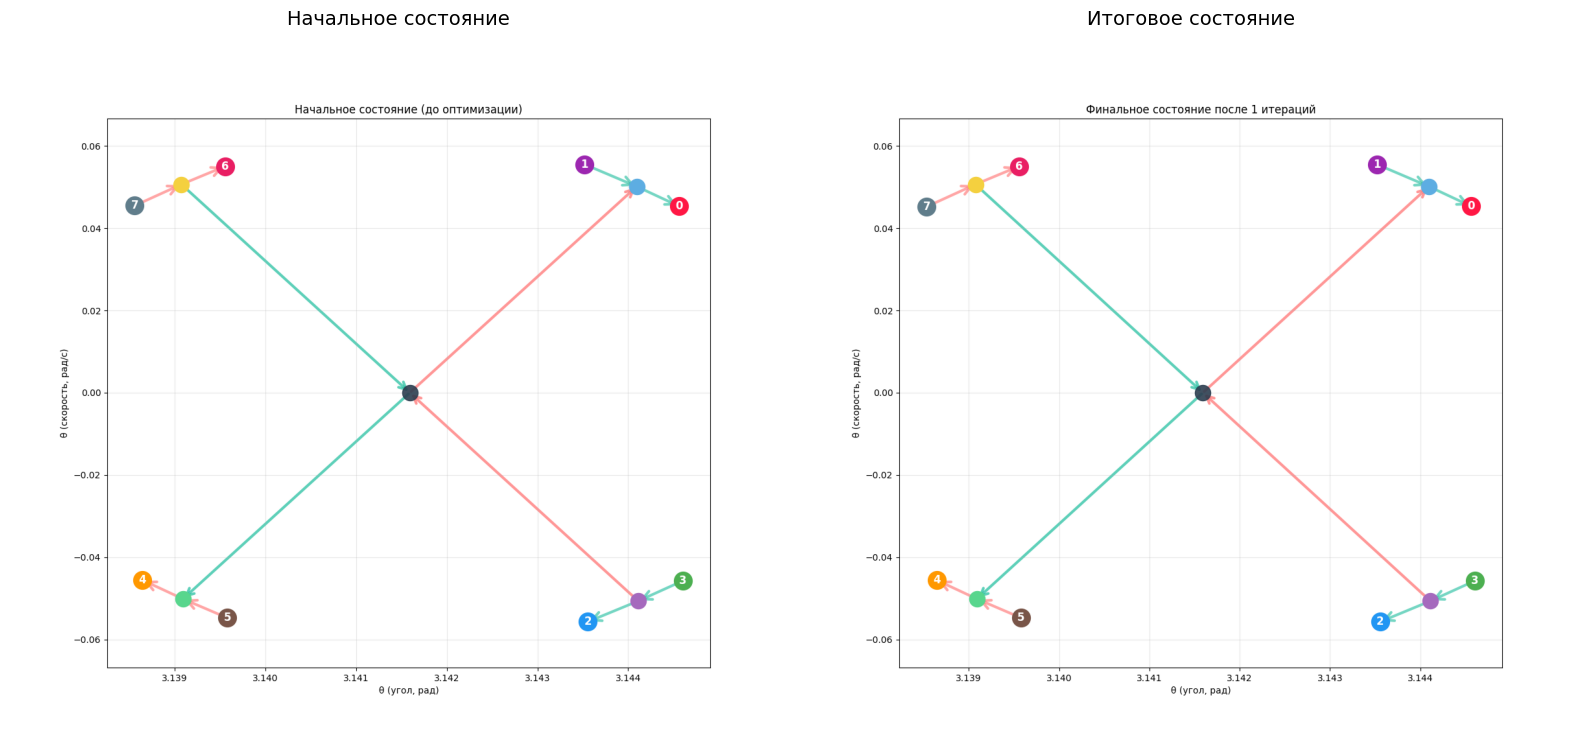

In [2]:
### 2. Визуализация состояний
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if latest_run_dir:
    # Пути к файлам
    initial_img_path = os.path.join(latest_run_dir, 'initial_state.png')
    final_img_path = os.path.join(latest_run_dir, 'final_state.png')
    s1_img_path = os.path.join(latest_run_dir, 'stage1_final_state.png')
    s2_img_path = os.path.join(latest_run_dir, 'stage2_final_state.png')

    # Определяем, какие файлы существуют
    has_initial = os.path.exists(initial_img_path)
    has_final = os.path.exists(final_img_path)
    has_s1 = os.path.exists(s1_img_path)
    has_s2 = os.path.exists(s2_img_path)

    image_paths = []
    titles = []

    # Определяем сценарий отображения
    if has_initial and has_s1 and has_s2:
        # Сценарий 1: Трехэтапный запуск
        image_paths = [initial_img_path, s1_img_path, s2_img_path]
        titles = ['Начальное состояние', 'После Этапа 1 (Поиск пар)', 'После Этапа 2 (Рост)']
    elif has_initial and has_final:
        # Сценарий 2: Одноэтапный запуск
        image_paths = [initial_img_path, final_img_path]
        titles = ['Начальное состояние', 'Итоговое состояние']
    elif has_initial:
        # Сценарий 3: Только начальное состояние
        image_paths = [initial_img_path]
        titles = ['Начальное состояние']
    
    # Рендеринг изображений
    if image_paths:
        num_images = len(image_paths)
        fig, axes = plt.subplots(1, num_images, figsize=(8 * num_images, 8))
        
        # Если только одно изображение, axes не будет массивом
        if num_images == 1:
            axes = [axes]
            
        for ax, path, title in zip(axes, image_paths, titles):
            try:
                img = mpimg.imread(path)
                ax.imshow(img)
                ax.set_title(title, fontsize=14)
                ax.axis('off')
            except FileNotFoundError:
                ax.text(0.5, 0.5, f"Файл не найден:\n{os.path.basename(path)}", ha='center', va='center')
                ax.set_title(title, fontsize=14)
                ax.axis('off')


        plt.tight_layout()
        plt.show()
    else:
        print("Не найдено ни одного изображения для отображения.")
else:
    print("Не удалось найти директорию с результатами.")



In [3]:
### 3. Анализ матриц расстояний
import numpy as np

def analyze_and_display_matrix(df, caption):
    """
    Функция для анализа матрицы: находит минимальные значения (кроме диагонали)
    и добавляет столбцы с результатами.
    """
    if df is None or df.empty:
        return None, None
        
    # Заменяем нули на диагонали на большое число
    df_no_diag = df.copy()
    np.fill_diagonal(df_no_diag.values, np.inf)

    # Находим минимальное значение в каждой строке и его индекс
    min_values = df_no_diag.min(axis=1)
    min_indices = df_no_diag.idxmin(axis=1)

    # Добавляем результаты в DataFrame
    df['min_dist'] = min_values
    df['best_pair_idx'] = min_indices
    
    # Стилизуем DataFrame
    styled_df = df.style.background_gradient(cmap='viridis', axis=None, subset=df.columns[:-2]) \
                        .format("{:.4f}", subset=pd.IndexSlice[:, df.columns[:-2]]) \
                        .set_caption(caption)
    
    return styled_df, df

if latest_run_dir:
    # Пути к файлам матриц
    initial_matrix_path = os.path.join(latest_run_dir, 'initial_distance_matrix.csv')
    final_matrix_path = os.path.join(latest_run_dir, 'final_distance_matrix.csv')
    s1_matrix_path = os.path.join(latest_run_dir, 'stage1_final_distance_matrix.csv')
    
    # Загружаем существующие матрицы
    initial_df, s1_df, final_df = None, None, None
    if os.path.exists(initial_matrix_path):
        initial_df = pd.read_csv(initial_matrix_path, header=None)
    if os.path.exists(s1_matrix_path):
        s1_df = pd.read_csv(s1_matrix_path, header=None)
    if os.path.exists(final_matrix_path):
        final_df = pd.read_csv(final_matrix_path, header=None)

    # Анализируем и стилизуем
    initial_styled, _ = analyze_and_display_matrix(initial_df.copy() if initial_df is not None else None, "Начальная матрица")
    s1_styled, _ = analyze_and_display_matrix(s1_df.copy() if s1_df is not None else None, "Матрица после Этапа 1")
    final_styled, _ = analyze_and_display_matrix(final_df.copy() if final_df is not None else None, "Итоговая матрица")
    
    # Собираем HTML для отображения
    html_parts = []
    if initial_styled:
        html_parts.append(f"<div>{initial_styled._repr_html_()}</div>")
    if s1_styled:
        html_parts.append(f"<div>{s1_styled._repr_html_()}</div>")
    if final_styled:
        html_parts.append(f"<div>{final_styled._repr_html_()}</div>")
    
    if html_parts:
        html_code = f"""
        <div style="display: flex; justify-content: space-around; flex-wrap: wrap;">
            {''.join(html_parts)}
        </div>
        """
        display(HTML(html_code))
    else:
        print("Не найдено файлов с матрицами для анализа.")
else:
    print("Не удалось найти директорию с результатами.")



,0,1,2,3,4,5,6,7,min_dist,best_pair_idx
0,0.0000,0.0001,0.0102,0.0083,0.0083,0.0100,0.0001,0.0000,0.000036,7
1,0.0001,0.0000,0.0124,0.0103,0.0103,0.0122,0.0000,0.0001,0.000016,6
2,0.0102,0.0124,0.0000,0.0001,0.0001,0.0000,0.0123,0.0103,0.000017,5
3,0.0083,0.0103,0.0001,0.0000,0.0000,0.0001,0.0102,0.0084,0.000036,4
4,0.0083,0.0103,0.0001,0.0000,0.0000,0.0001,0.0101,0.0083,0.000036,3
5,0.0100,0.0122,0.0000,0.0001,0.0001,0.0000,0.0121,0.0101,0.000017,2
6,0.0001,0.0000,0.0123,0.0102,0.0101,0.0121,0.0000,0.0001,0.000016,1
7,0.0000,0.0001,0.0103,0.0084,0.0083,0.0101,0.0001,0.0000,0.000036,0
,0,1,2,3,4,5,6,7,min_dist,best_pair_idx
0,0.0000,0.0001,0.0102,0.0083,0.0083,0.0100,0.0001,0.0000,0.000036,7


In [4]:
### 6. Финальная визуализация и сохранение артефактов

if 'result' in locals() and result.success:
    # 1. Получаем финальные позиции X
    final_dt = result.x
    evaluator._build_if_needed(final_dt)
    final_X = np.array([gc['position'] for gc in tree.grandchildren])

    # 2. Рассчитываем финальную матрицу P и стоимости C
    # Используем минимальный eps из расписания для "четкого" результата
    final_eps = sk_config.annea_schedule[-1]
    final_sk_cfg = SinkhornConfig(eps=final_eps, n_iter=sk_config.n_iter)
    
    final_C = pairwise_sqdist(final_X)
    if loss_config.forbid_self:
        np.fill_diagonal(final_C, 1e6)
        
    final_P = sinkhorn(final_C, final_sk_cfg)

    # 3. Собираем метрики для сохранения
    mean_paired_distance = (final_P * final_C).sum() / final_X.shape[0]
    
    final_metrics = {
        "final_loss": result.fun,
        "mean_paired_distance": mean_paired_distance,
        "final_eps": final_eps,
        "optimizer_message": result.message,
        "total_iterations": result.nit,
        "final_dt_params": final_dt,
        "P_matrix": final_P,
        "C_matrix": final_C
    }
    
    # 4. Визуализируем и сохраняем
    plot_points_and_arrows(
        X=final_X,
        P=final_P,
        starts=initial_X,  # Используем начальные X из ячейки 2
        title=f"Финальное состояние после {result.nit} итераций",
        save_dir=config_yaml['logging']['out_dir'],
        metrics=final_metrics
    )
else:
    print("Оптимизация не была успешно завершена. Пропустите этот шаг.")


Оптимизация не была успешно завершена. Пропустите этот шаг.


In [5]:
### 4. Анализ метрик и найденных пар
import json

def find_and_print_pairs(metrics_dict):
    """Рекурсивный поиск и вывод информации о парах в словаре метрик."""
    pairs_found = False
    if isinstance(metrics_dict, dict):
        for key, value in metrics_dict.items():
            if key == 'found_pairs' and isinstance(value, list) and value:
                print(f"Найдены пары в '{key}':")
                for pair in value:
                     print(f"  • Внук {pair[0]} ↔️ Внук {pair[1]}")
                pairs_found = True
            elif isinstance(value, dict):
                pairs_found = find_and_print_pairs(value) or pairs_found
            elif isinstance(value, list):
                for item in value:
                    pairs_found = find_and_print_pairs(item) or pairs_found
    return pairs_found

if latest_run_dir:
    metrics_path = os.path.join(latest_run_dir, 'metrics.json')
    if os.path.exists(metrics_path):
        with open(metrics_path, 'r') as f:
            try:
                metrics = json.load(f)
                
                print("="*20 + " Анализ файла метрик " + "="*20)
                if not find_and_print_pairs(metrics):
                    print("\nИнформация о зафиксированных парах не найдена в файле метрик.")
                
                # Можно добавить вывод других метрик, если нужно
                # Например, итоговую потерю:
                if 'final_loss' in metrics:
                    print(f"\nИтоговое значение функции потерь: {metrics['final_loss']:.4f}")
                    
            except json.JSONDecodeError:
                print("Ошибка: Не удалось прочитать файл метрик (неверный формат JSON).")
    else:
        print(f"Файл метрик не найден: {metrics_path}")
else:
    print("Не удалось найти директорию с результатами.")



==================== Анализ файла метрик ====================

Информация о зафиксированных парах не найдена в файле метрик.

Итоговое значение функции потерь: 0.1640
